
   TUNING GRADIENT BOOSTING
1. Training Base Model...
   > Base Model MAE: 7.83 MPa

2. Training Correction Model...
   > Running Grid Search to find optimal hyperparameters...
   > Best Settings Found: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}

3. Validating Full System...
   > FINAL MAE: 8.28 MPa


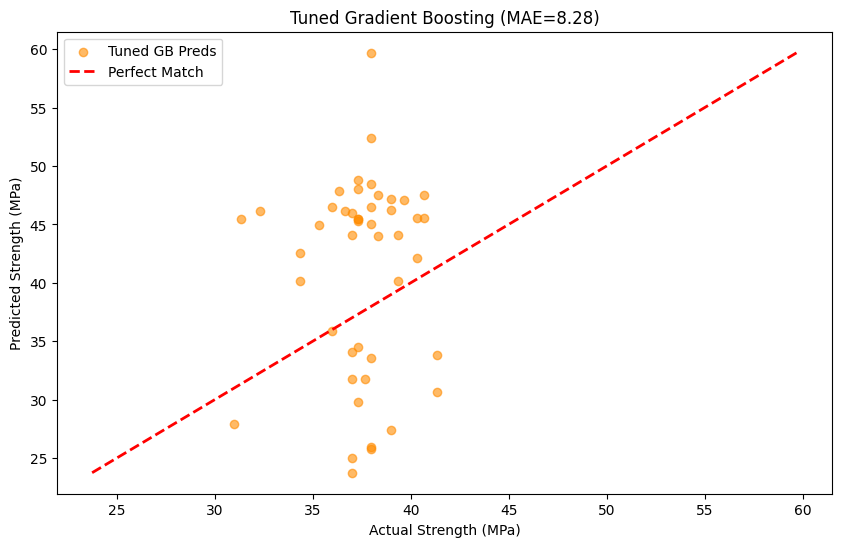

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# --- 1. LOAD DATA ---
# (Assuming df_kaggle and df_local are already loaded from previous cells)
# If not, uncomment these:
# df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
# df_local = pd.read_csv("Data/localdataset.csv")

# --- 2. HELPER FUNCTION (Same as before - keeping it for completeness) ---
def train_helper_data(df):
    recipe_cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate']
    df.columns = df.columns.str.strip() 
    
    # Train Helper
    df_7 = df[df['Age'] == 7].copy()
    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    helper_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    helper_model.fit(X_helper, y_helper)

    # Impute
    df_28 = df[df['Age'] == 28].copy()
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index().rename(columns={'Strength': 'Real_Strength_7'})
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    
    final_dataset = df_augmented[['Strength_7', 'Strength']].copy().rename(columns={'Strength': 'Strength_28'})
    return final_dataset

# --- 3. TUNED TRAINING FUNCTION ---
def process_tuned_gradient_boosting(df_helper, df_local):
    print("\n" + "="*40)
    print("   TUNING GRADIENT BOOSTING")
    print("="*40)

    # A. TRAIN BASE MODEL (The "Lab Curve")
    print("1. Training Base Model...")
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    
    # TUNING CHANGE 1: More estimators, slightly deeper trees for the base curve
    base_model = GradientBoostingRegressor(
        n_estimators=500,       # increased from 300
        learning_rate=0.05, 
        max_depth=4,            # increased from 3 (allows slightly more complex curves)
        min_samples_leaf=5,     # stability constraint
        random_state=42
    )
    base_model.fit(X_train_b, y_train_b)
    
    # Check Accuracy
    base_preds = base_model.predict(X_test_b)
    print(f"   > Base Model MAE: {mean_absolute_error(y_test_b, base_preds):.2f} MPa")

    # B. TRAIN CORRECTION MODEL (The "Weather" Adjuster)
    print("\n2. Training Correction Model...")
    
    # Generate Base Predictions & Residuals
    df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])
    df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']
    
    X_corr = df_local[['avgTemp']]
    y_corr = df_local['Residual']
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)
    
    # TUNING CHANGE 2: Aggressive tuning for the Correction Model
    # We use GridSearchCV to automatically find the BEST settings for your specific local data
    param_grid = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4]
    }
    
    print("   > Running Grid Search to find optimal hyperparameters...")
    gb_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=3, # 3-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    gb_search.fit(X_train_c, y_train_c)
    
    correction_model = gb_search.best_estimator_
    print(f"   > Best Settings Found: {gb_search.best_params_}")

    # C. FINAL VALIDATION
    print("\n3. Validating Full System...")
    
    test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
    pred_base_part = base_model.predict(test_inputs_base)
    
    test_inputs_corr = X_test_c
    pred_corr_part = correction_model.predict(test_inputs_corr)
    
    final_predictions = pred_base_part + pred_corr_part
    actual_values = df_local.loc[X_test_c.index, 'Strength_28']
    
    final_mae = mean_absolute_error(actual_values, final_predictions)
    
    print(f"   > FINAL MAE: {final_mae:.2f} MPa")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='darkorange', alpha=0.6, label='Tuned GB Preds')
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"Tuned Gradient Boosting (MAE={final_mae:.2f})")
    plt.legend()
    plt.show()
    
    return base_model, correction_model

# --- 4. EXECUTE ---
df_helper = train_helper_data(df_kaggle)
base_model_gb, correction_model_gb = process_tuned_gradient_boosting(df_helper, df_local)